# Benchmarks Pythagorean three body (adaptive step size)

## Loading packages and functions

In [1]:
using LinearAlgebra, Plots
using OrdinaryDiffEq
using NbodyIRKGL16

In [2]:
#to install NbodyIRKGL16.jl package
# using Pkg
# Pkg.add(url="https://github.com/mikelehu/NbodyIRKGL16.jl") 


#Local version
#PATH_SRC="../src/"
#include(string(PATH_SRC,"NbodyIRKGL16.jl"))
#using .NbodyIRKGL16 

### Some aux functions

In [3]:
function run_many_NbodyIRKGL(ddt0, tspan,u0, parms, HAM;simdB=true, adaptiveB=true)

    nruns=10
    
    u0_B=BigFloat.(u0)
    Gm_B=BigFloat.(parms)
    
    cpus=similar(ddt0)
    iters=similar(ddt0)
    retcodes=[true for k in ddt0]
    MaxΔHglobal=[0. for i in ddt0]
    MaxΔHlocal=[0. for i in ddt0]
    
    sols=Array{NbodyIRKGL16.ODESolution}(undef,length(ddt0))
    prob = ODEProblem{true,SciMLBase.FullSpecialize}(NbodyODE_with_step_size!, u0, tspan , Gm)
    H0=HAM(u0_B,Gm_B)
    
    for i in 1:length(ddt0)
        
        print(",",ddt0[i])    
        dt0=ddt0[i]
        
        # save_everystep=true
        m0=1
        alg=nbirkgl16(simd=simdB, second_order_ode=true, mstep=m0)
        sols[i]=solve(prob,alg,dt=dt0,adaptive=adaptiveB)
        if sols[i].retcode==ReturnCode.Success
           iters[i]=sols[i].stats.nfpiter
        else
           retcodes[i]=false
           iters[i]=Inf
        end

        m0 = max(1,div(Int64(ceil((tF-t0)/ddt0[i])),1000))      
        H = [HAM(BigFloat.(u),Gm_B) for u in sols[i].u]
        ΔH0 = @. Float64(abs(H/H0-1))
        H_lerr = @. Float64(abs((H[2:end] / H[1:end-1]) - 1))
        MaxΔHglobal[i]=maximum(ΔH0)
        MaxΔHlocal[i]=maximum(H_lerr)
 
        # save_everystep=false
        solx=solve(prob,alg,dt=dt0,adaptive=adaptiveB,save_everystep = false)
        if solx.retcode==ReturnCode.Success
           cpus[i]=0.
           for k in 1:nruns
               cpus[i]+=@elapsed solve(prob,alg,dt=dt0,adaptive=adaptiveB, save_everystep = false)
           end
           cpus[i]=cpus[i]/nruns
        else
           cpus[i]=Inf
        end
        
    end

    return sols,retcodes,iters,cpus,MaxΔHglobal,MaxΔHlocal

end    


function plots_NbodyIRKGL(title,ddt0, u0, parms, HAM, sols,iters,cpus,MaxΔH)
    
    u0_B=BigFloat.(u0)
    Gm_B=BigFloat.(parms)
    
    H0=HAM(u0_B,Gm_B)
    MaxΔH=[0. for i in ddt0]

    pl1=plot(ddt0,cpus, seriestype=:scatter,label="", 
             title="CPU-time", xlabel="dt", ylabel="CPU");
    pl2=plot(ddt0,iters, seriestype=:scatter, label="",
         title="Iterations", xlabel="dt", ylabel="iter");

    pl3=plot(title="Error in Ham",xlabel="t ", ylabel="log10(H/H0)", 
              yscale=:log10, label="")

     for  i in 1:length(ddt0)
          m0 = max(1,div(Int64(ceil((tF-t0)/ddt0[i])),1000))
          ΔH0 = map(x->HAM(BigFloat.(x),Gm_B), sols[i].u)./H0.-1 
          pl3=plot!(sols[i].t[2:m0:end],abs.(ΔH0[2:m0:end]), labels="")
     end

     fig=plot(pl1,pl2,pl3, layout=(1,3), size=(950,300),plot_title=title, plot_titlevspan=0.2)
     return fig
    
end

plots_NbodyIRKGL (generic function with 1 method)



## Definition of the N-body problem


In [4]:
PATH_ODES="../ODEProblems/"

include(string(PATH_ODES,"InitialPythagorean3BP.jl"))
include(string(PATH_ODES,"Nbody.jl"));

### Initial value problem:The Pythagorean three body problem

A planar three-body problem. It consists of three masses in the ratio 3:4:5 placed at rest
at the vertices of a 3:4:5 right triangle. Szebehely and Peters [15] found, by numerically
integrating the problem (using Levi--Civita renormalization near close encounters), that after
several binary close encounters a stable binary is formed between the two heaviest bodies
while the third one is ejected from the system.



In [5]:
u0, Gm, bodylist = InitialPythagorean3BP(Float64)

q0=u0[:,:,1]
v0=u0[:,:,2]

N = length(Gm)

show(bodylist)
E0=NbodyEnergy(u0,Gm)

["Body-1", "Body-2", "Body-3"]

-12.816666666666668

In [6]:
t0=0.
tF=63.  
tspan= (t0,tF)

prob = ODEProblem(NbodyODE_with_step_size!, u0,tspan , Gm);

##### <a href="#top">Back to the top</a>

## Integrations

HAM(u0, Gm) = -12.816666666666668
,0.2,0.3,0.4,0.5,0.6

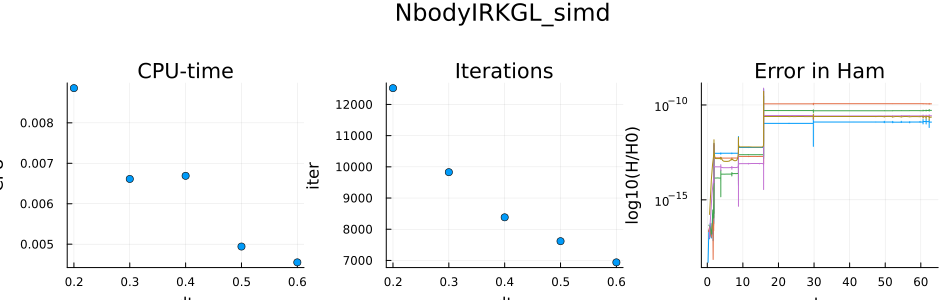

,0.2,0.3,0.4,0.5,0.6

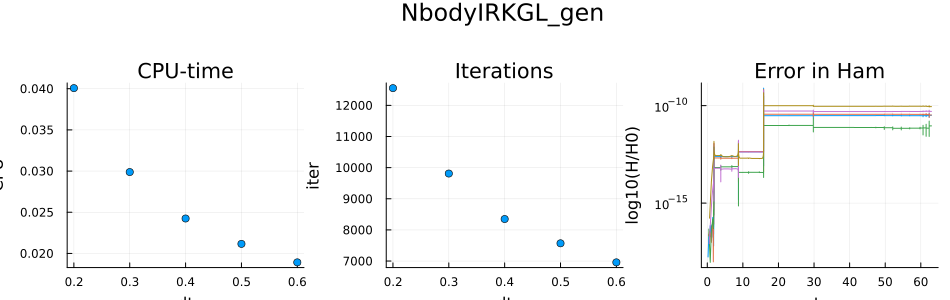

In [7]:
HAM=NbodyEnergy
@show(HAM(u0,Gm))

ddt0=collect(0.2:0.1:0.6)
#ddt0=collect(0.05:0.05:0.6)
#ddt0=[0.2]
  
sols_simd,retcodes_simd,iters_simd,cpus_simd,MaxΔHglobal_simd,MaxΔHlocal_simd=
run_many_NbodyIRKGL(ddt0, tspan, u0, Gm, HAM; simdB=true, adaptiveB=true)
fig=plots_NbodyIRKGL("NbodyIRKGL_simd",ddt0,u0, Gm,HAM,sols_simd,iters_simd,cpus_simd,MaxΔHlocal_simd)
display(fig)
#
sols_gen,retcodes_gen,iters_gen,cpus_gen, MaxΔHglobal_gen, MaxΔHlocal_gen=
run_many_NbodyIRKGL(ddt0, tspan, u0, Gm, HAM; simdB=false, adaptiveB=true)
fig=plots_NbodyIRKGL("NbodyIRKGL_gen",ddt0,u0, Gm, HAM,sols_gen,iters_gen,cpus_gen,MaxΔHlocal_gen)
display(fig)

# Work-precision diagrams

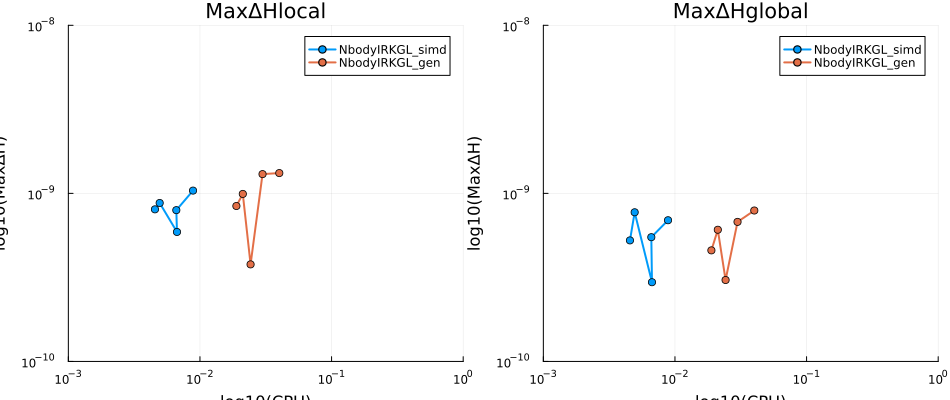

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict

In [8]:
yrange=(1e-10, 1e-8)
xrange=(1e-3,1e0)
pl1=plot( cpus_simd , MaxΔHlocal_simd, scale=:log10,
          markershape=:circle, lw=2,
          ylimits=yrange, xlimits=xrange,
          title="MaxΔHlocal", xlabel="log10(CPU)", ylabel="log10(MaxΔH)", label="NbodyIRKGL_simd")
plot!(pl1, cpus_gen , MaxΔHlocal_gen, 
      markershape=:circle, lw=2,
      scale=:log10, xlabel="log10(CPU)", ylabel="log10(MaxΔH)", label="NbodyIRKGL_gen")


pl2=plot( cpus_simd , MaxΔHglobal_simd, scale=:log10,
         markershape=:circle, lw=2,
         ylimits=yrange, xlimits=xrange,
         title="MaxΔHglobal", xlabel="log10(CPU)", ylabel="log10(MaxΔH)", label="NbodyIRKGL_simd")

plot!(pl2, cpus_gen , MaxΔHglobal_gen,
     markershape=:circle, lw=2,
           scale=:log10, xlabel="log10(CPU)", ylabel="log10(MaxΔH)", label="NbodyIRKGL_gen")

plot(pl1,pl2, layout=(1,2), size=(950,400)) #plot_title="", plot_titlevspan=0.2)